<a href="https://colab.research.google.com/github/khushalibegde/ECG_Anomaly_Detection/blob/main/ECG_Anamoly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### dataset: https://physionet.org/content/mitdb/1.0.0/

Dataset has different file formats:

.dat → ECG signal values

.hea → how to read .dat

.atr → where the anomalies are (annotations)

so using wfdb to read these files

In [1]:
!pip install wfdb

  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.4.0-py3-none-any.whl.metadata (3.7 kB)
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ------------ --------------------------- 3.4/11.0 MB 18.3 MB/s eta 0:00:01
   ----------------- ---------------------- 4.7/11.0 MB 10.9 MB/s eta 0:00:01
   -------------------- ------------------- 5.8/11.0 MB 8.8 MB/s eta 0:00:01
   ---------------------- ----------------- 6.3/11.0 MB 7.3 MB/s eta 0:00:01
   ------------------------ --------------- 6.8/11.0 MB 6.6 MB/s eta 0:00:01
   -------------------------- ------------- 7.3/11.0 MB 5.9 MB/s eta 0:00:01
   ----------------------------- ---------- 8.1/11.0 MB 5.3 MB/s eta 0:00:01
   ------------------------------- -------- 8.7/11.0 MB 5.1 MB/s eta 0:00:01
   ---------------------------------- ----- 9.4/11.0 MB 4.8 MB/s eta 0:00:01
   ------------------------------------- -- 10.2/11.0 MB 4.7 MB/s eta 0:00:01
   ---------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.37.1 requires protobuf<6,>=3.20, but you have protobuf 6.32.1 which is incompatible.


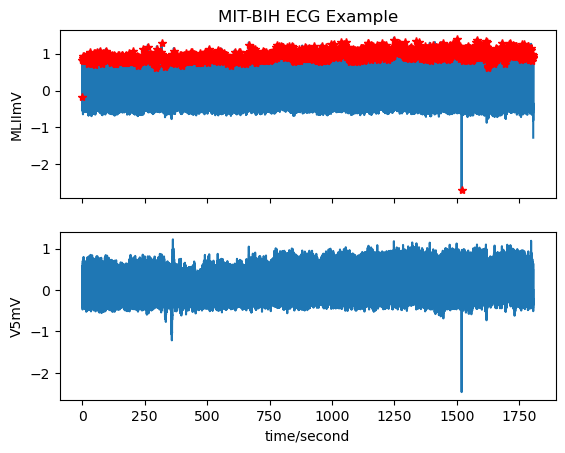

In [2]:
import wfdb
import matplotlib.pyplot as plt

record = wfdb.rdrecord('100', pn_dir='mitdb')
annotation = wfdb.rdann('100', 'atr', pn_dir='mitdb')

wfdb.plot_wfdb(record=record, annotation=annotation, title='MIT-BIH ECG Example')

In [4]:
import wfdb
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm

record_names = wfdb.get_record_list('mitdb')
print(f"Total {len(record_names)} records found: {record_names}")

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut=0.5, highcut=40, fs=360):
    b, a = butter_bandpass(lowcut, highcut, fs)
    y = filtfilt(b, a, data)
    return y

all_beats = []
all_labels = []
all_rr_intervals = []

for rec in tqdm(record_names, desc="Processing Records"):
    try:
        record = wfdb.rdrecord(rec, pn_dir='mitdb')
        annotation = wfdb.rdann(rec, 'atr', pn_dir='mitdb')

        fs = record.fs

        signal = record.p_signal[:, 0]
        filtered = bandpass_filter(signal, fs=record.fs)

        rr_samples = np.diff(annotation.sample, prepend=0)

        for i in range(len(annotation.sample) - 1):

            start_idx = annotation.sample[i]
            end_idx = annotation.sample[i + 1]

            beat = filtered[start_idx:end_idx]

            if i == 0:
                continue

            all_beats.append(beat)
            all_labels.append(annotation.symbol[i])

            all_rr_intervals.append(rr_samples[i] / fs)

    except Exception as e:
        print(f"Error reading record {rec}: {e}")

norm_beats = [ (b - np.mean(b)) / np.std(b) for b in all_beats ]

padded_beats = pad_sequences(norm_beats, dtype='float32', padding='post', maxlen=200)

df = pd.DataFrame(padded_beats)

df['label'] = all_labels
df['rr_interval_sec'] = all_rr_intervals

print(f"\nFinal dataset shape: {df.shape}")
display(df.head())

df.to_csv('mitbih_all_processed_corrected.csv', index=False)

Total 48 records found: ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']


Processing Records: 100%|██████████████████████████████████████████████████████████████| 48/48 [10:49<00:00, 13.54s/it]



Final dataset shape: (112551, 202)


,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,label,rr_interval_sec
0,-0.586329,-0.601858,-0.607349,-0.602703,-0.590802,-0.576757,-0.565822,-0.561027,-0.562094,-0.566190,...,-0.691603,-0.023417,0.964214,2.242639,3.716783,5.222131,6.543328,7.455434,N,0.163889
1,-0.673191,-0.685310,-0.696791,-0.708729,-0.720694,-0.731503,-0.740578,-0.748476,-0.756014,-0.762789,...,-1.355380,-1.155956,-0.619900,0.313606,1.630171,3.210836,4.826827,6.173148,N,0.813889
2,-0.403355,-0.416598,-0.425561,-0.430973,-0.434812,-0.439732,-0.447665,-0.458432,-0.469522,-0.477511,...,-1.496228,-1.170938,-0.563756,0.373670,1.633945,3.120550,4.634881,5.901722,N,0.811111
3,-0.372888,-0.373258,-0.370062,-0.363882,-0.355230,-0.345204,-0.336362,-0.332437,-0.336528,-0.348843,...,-1.463893,-1.144863,-0.437834,0.682065,2.141525,3.752559,5.231676,6.262034,N,0.788889
4,-0.611277,-0.640648,-0.669551,-0.698467,-0.726676,-0.751648,-0.769012,-0.773858,-0.763394,-0.739517,...,-1.233765,-0.776904,0.063810,1.299796,2.840197,4.477663,5.914838,6.835203,N,0.791667


In [5]:
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks

df = pd.read_csv('mitbih_all_processed_corrected.csv')

y_labels = df['label']
y_rr_intervals = df['rr_interval_sec']
X_signal = df.drop(columns=['label', 'rr_interval_sec'])

def extract_all_features(beat):
    stat_features = {
        'mean': np.mean(beat),
        'std': np.std(beat),
        'min': np.min(beat),
        'max': np.max(beat),
        'energy': np.sum(np.square(beat)),
        'skewness': skew(beat),
        'kurtosis': kurtosis(beat)
    }

    peaks, _ = find_peaks(beat, distance=30)
    if len(peaks) > 0:
        r_peak_amplitude = beat[peaks].max()
    else:
        r_peak_amplitude = np.nan

    stat_features['r_peak_amplitude'] = r_peak_amplitude

    return stat_features

feature_list = []
for row in tqdm(X_signal.values, desc="Extracting Features"):
    feature_list.append(extract_all_features(row))

stat_df = pd.DataFrame(feature_list)

df_features = pd.concat([X_signal, stat_df], axis=1)
df_features['rr_interval_sec'] = y_rr_intervals
df_features['label'] = y_labels

print("\nFinal Feature Matrix Shape:", df_features.shape)
display(df_features.head())

df_features.to_csv("mitbih_all_features_corrected.csv", index=False)

Extracting Features: 100%|████████████████████████████████████████████████████| 112551/112551 [03:54<00:00, 478.95it/s]



Final Feature Matrix Shape: (112551, 210)


,0,1,2,3,4,5,6,7,8,9,...,mean,std,min,max,energy,skewness,kurtosis,r_peak_amplitude,rr_interval_sec,label
0,-0.586329,-0.601858,-0.607349,-0.602703,-0.590802,-0.576757,-0.565822,-0.561027,-0.562094,-0.566190,...,0.145604,0.903450,-1.187726,7.455434,167.484518,5.585946,37.480131,0.687463,0.163889,N
1,-0.673191,-0.685310,-0.696791,-0.708729,-0.720694,-0.731503,-0.740578,-0.748476,-0.756014,-0.762789,...,0.040831,0.710242,-1.355380,6.173148,101.222052,5.026527,37.604098,0.618417,0.813889,N
2,-0.403355,-0.416598,-0.425561,-0.430973,-0.434812,-0.439732,-0.447665,-0.458431,-0.469522,-0.477511,...,0.005573,0.703167,-1.609934,5.901722,98.894867,4.540254,33.880294,0.525573,0.811111,N
3,-0.372888,-0.373258,-0.370062,-0.363882,-0.355230,-0.345204,-0.336362,-0.332437,-0.336528,-0.348843,...,0.038057,0.727066,-1.482621,6.262034,106.014791,5.566994,40.971104,0.495533,0.788889,N
4,-0.611277,-0.640648,-0.669551,-0.698467,-0.726676,-0.751648,-0.769012,-0.773858,-0.763394,-0.739517,...,0.075960,0.841944,-1.383365,6.835203,142.927912,5.001610,33.927871,0.715594,0.791667,N


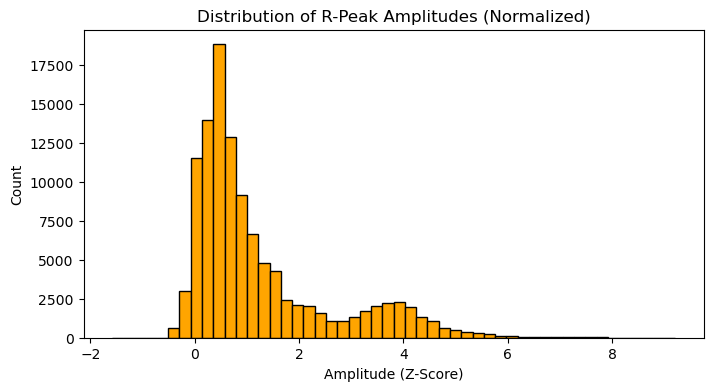

In [6]:
df = pd.read_csv("mitbih_all_features_corrected.csv")

plt.figure(figsize=(8, 4))
plt.hist(df['r_peak_amplitude'].dropna(), bins=50, color='orange', edgecolor='black')
plt.title("Distribution of R-Peak Amplitudes (Normalized)")
plt.xlabel("Amplitude (Z-Score)")
plt.ylabel("Count")
plt.show()

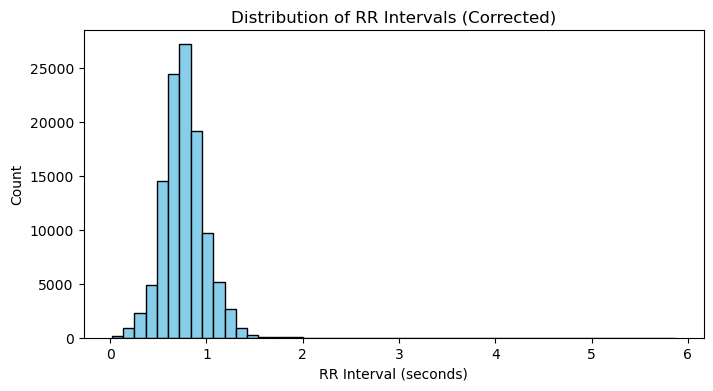

In [7]:
plt.figure(figsize=(8, 4))
plt.hist(df['rr_interval_sec'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of RR Intervals (Corrected)")
plt.xlabel("RR Interval (seconds)")
plt.ylabel("Count")
plt.show()

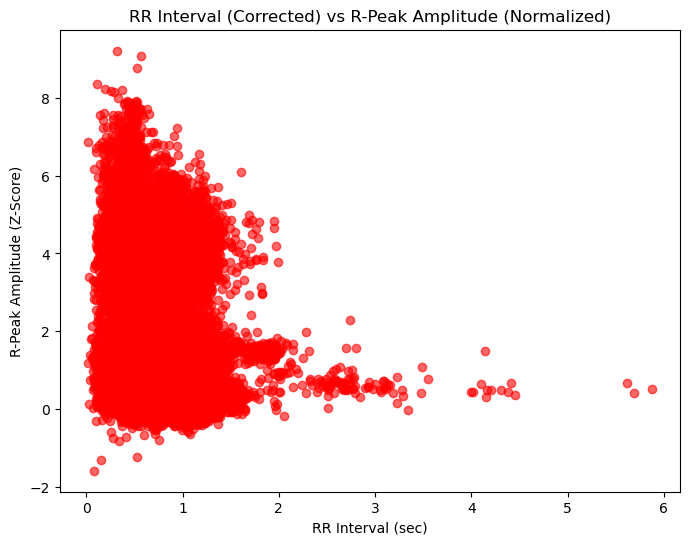

In [8]:
plt.figure(figsize=(8, 6))
plt.scatter(df['rr_interval_sec'], df['r_peak_amplitude'], c='red', alpha=0.6)
plt.title("RR Interval (Corrected) vs R-Peak Amplitude (Normalized)")
plt.xlabel("RR Interval (sec)")
plt.ylabel("R-Peak Amplitude (Z-Score)")
plt.show()

In [9]:
import numpy as np
import pandas as pd
from scipy.signal import spectrogram
from tqdm import tqdm

def extract_spectral_energy(beat, fs=360):
    f, t, Sxx = spectrogram(beat, fs=fs, nperseg=32)
    spectral_energy = np.sum(Sxx)

    return spectral_energy

df_final = pd.read_csv('mitbih_all_features_corrected.csv')

signal_cols = [str(i) for i in range(200)]
X_signal = df_final[signal_cols]

spectral_features = []
for index, row in tqdm(X_signal.iterrows(), total=len(X_signal), desc="Extracting Spectral Features"):
    beat = row.values

    energy = extract_spectral_energy(beat, fs=360)
    spectral_features.append(energy)

df_spectral = pd.DataFrame({'spectral_energy': spectral_features})

df_final = pd.concat([df_final, df_spectral], axis=1)

print("\nFinal Feature Matrix Shape with Spectral Features:", df_final.shape)
display(df_final.head())

df_final.to_csv("mitbih_final_complete_features.csv", index=False)

Extracting Spectral Features: 100%|██████████████████████████████████████████| 112551/112551 [00:44<00:00, 2515.05it/s]



Final Feature Matrix Shape with Spectral Features: (112551, 211)


,0,1,2,3,4,5,6,7,8,9,...,std,min,max,energy,skewness,kurtosis,r_peak_amplitude,rr_interval_sec,label,spectral_energy
0,-0.586329,-0.601858,-0.607349,-0.602703,-0.590802,-0.576757,-0.565822,-0.561027,-0.562094,-0.566190,...,0.903450,-1.187726,7.455434,167.484518,5.585946,37.480131,0.687463,0.163889,N,0.218969
1,-0.673191,-0.685310,-0.696791,-0.708729,-0.720694,-0.731503,-0.740578,-0.748476,-0.756014,-0.762789,...,0.710242,-1.355380,6.173148,101.222052,5.026527,37.604098,0.618417,0.813889,N,0.113229
2,-0.403355,-0.416598,-0.425561,-0.430973,-0.434812,-0.439732,-0.447665,-0.458431,-0.469522,-0.477511,...,0.703167,-1.609934,5.901722,98.894867,4.540254,33.880294,0.525573,0.811111,N,0.125893
3,-0.372888,-0.373258,-0.370062,-0.363882,-0.355230,-0.345204,-0.336362,-0.332437,-0.336528,-0.348843,...,0.727066,-1.482621,6.262034,106.014791,5.566994,40.971104,0.495533,0.788889,N,0.133818
4,-0.611277,-0.640648,-0.669551,-0.698467,-0.726676,-0.751648,-0.769012,-0.773858,-0.763394,-0.739517,...,0.841944,-1.383365,6.835203,142.927912,5.001610,33.927871,0.715594,0.791667,N,0.178283
